In [2]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, HistoricAverage,RandomWalkWithDrift)
from datasetsforecast.losses import mse, mae, smape
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2019-01-01', end='2023-12-31', interval='1d')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})

# Calcular los retornos
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,ds,unique_id,y
0,2019-01-03,AAPL,-0.104924
1,2019-01-04,AAPL,0.041803
2,2019-01-08,AAPL,0.018884
3,2019-01-09,AAPL,0.016839
4,2019-01-10,AAPL,0.003191
...,...,...,...
8735,2023-12-21,NVDA,0.018105
8736,2023-12-22,NVDA,-0.003271
8737,2023-12-27,NVDA,0.002796
8738,2023-12-28,NVDA,0.002123


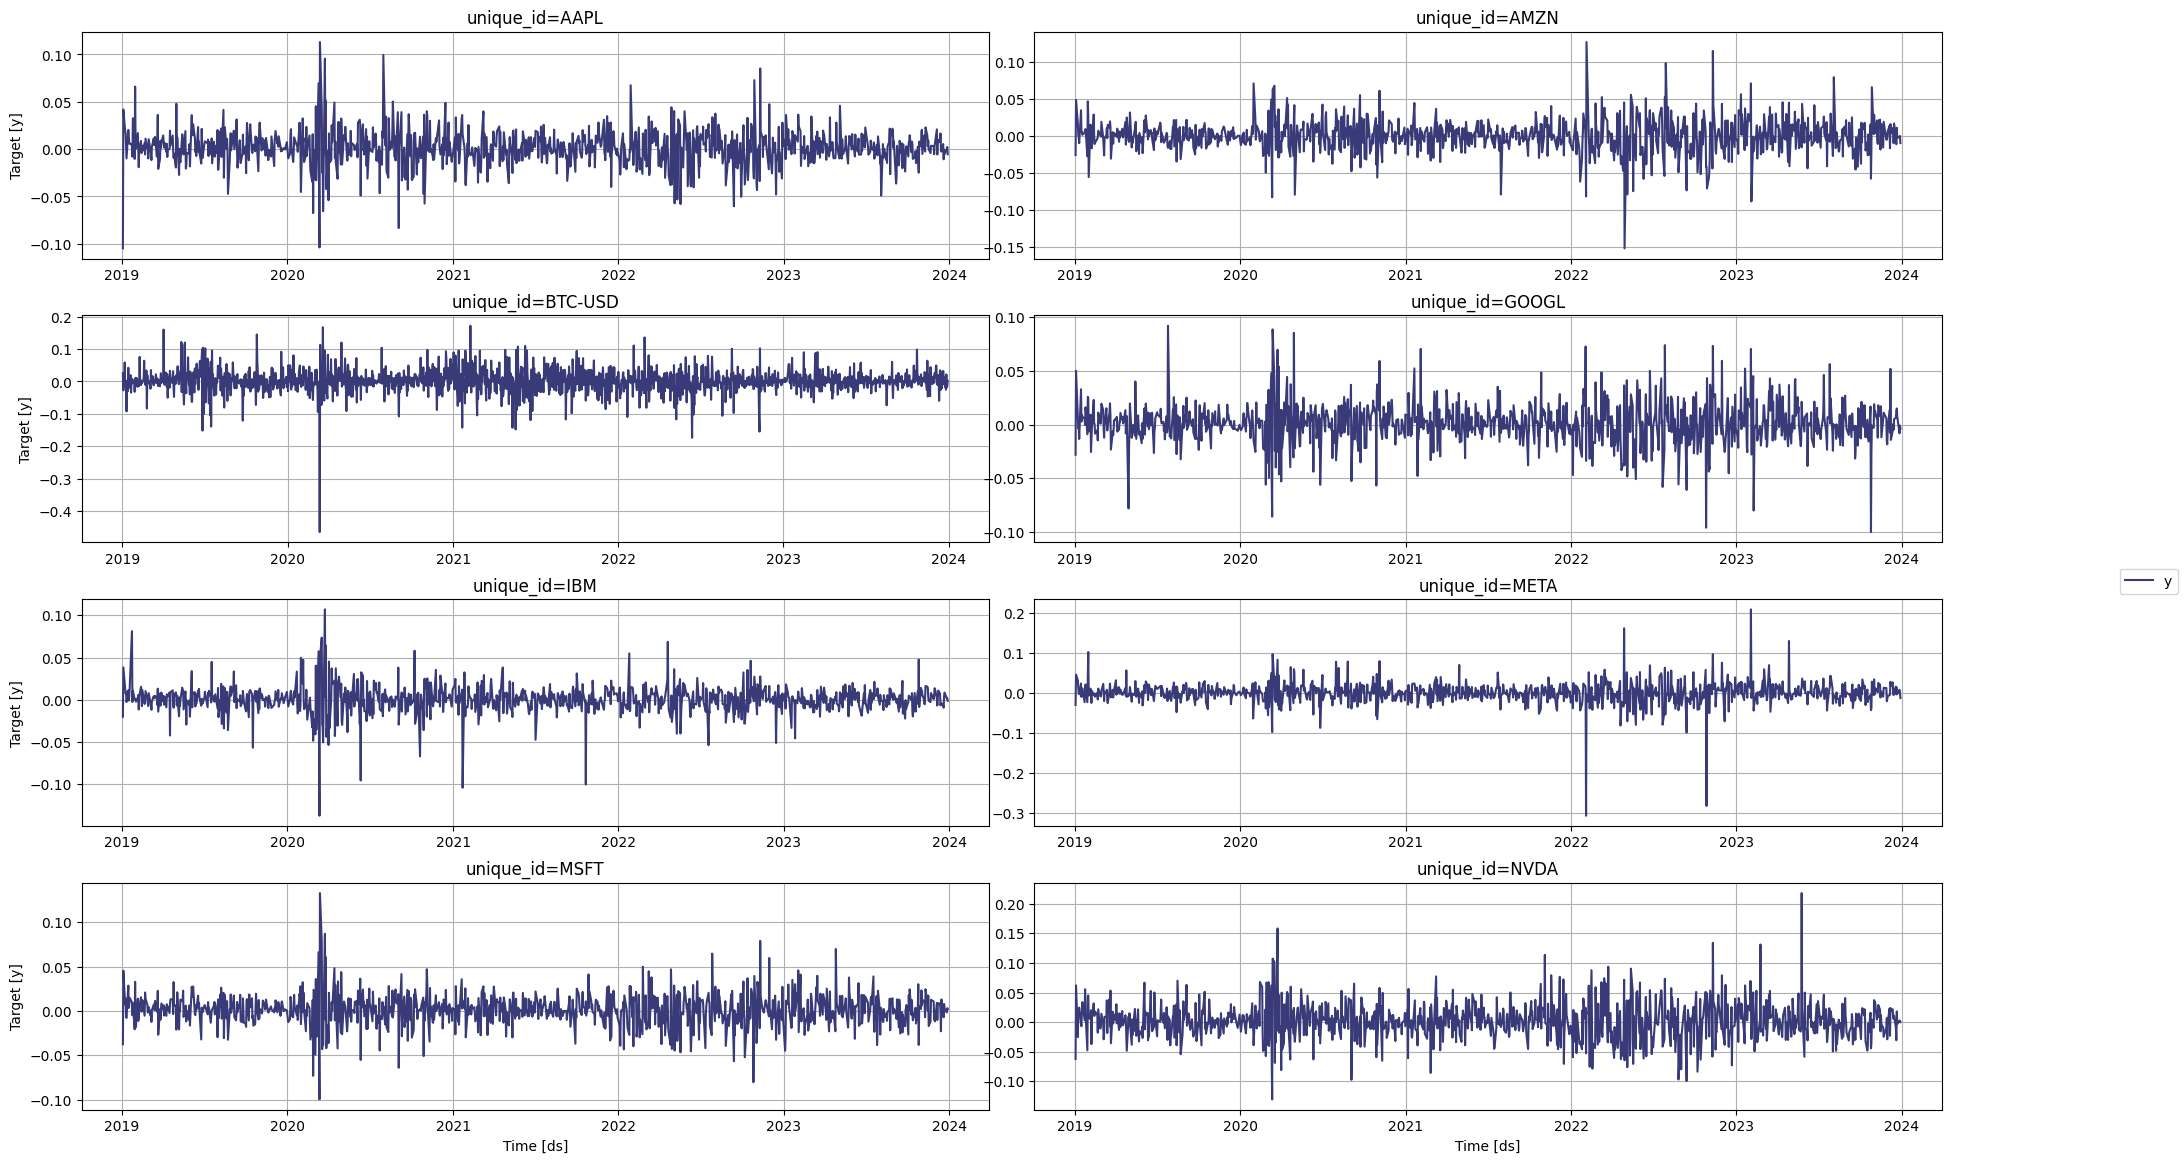

In [4]:
StatsForecast.plot(Y_df)

In [5]:
season_length = 7
horizon = 28

models = [
    Naive(),
    HistoricAverage(), 
    RandomWalkWithDrift(),
    SeasonalNaive(season_length=season_length),
]

# Instantiate StatsForecast class with models, data frequency ('MS' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='D',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [6]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=Y_df, h=horizon) # forecast data
Y_hat_df.head() 

,ds,Naive,HistoricAverage,RWD,SeasonalNaive
unique_id,,,,,
AAPL,2023-12-30,-0.005439,0.001226,-0.005338,0.005346
AAPL,2023-12-31,-0.005439,0.001226,-0.005237,-0.010772
AAPL,2024-01-01,-0.005439,0.001226,-0.005136,-0.000770
AAPL,2024-01-02,-0.005439,0.001226,-0.005036,-0.005563
AAPL,2024-01-03,-0.005439,0.001226,-0.004935,0.000518


In [7]:
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=5, step_size=horizon, level=[90])
cv_df.head()

,ds,cutoff,y,Naive,Naive-lo-90,Naive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,RWD,RWD-lo-90,RWD-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,,,,,,,
AAPL,2023-04-18,2023-04-14,0.007477,-0.002116,-0.052663,0.048431,0.001306,-0.032879,0.035491,-0.001995,-0.052571,0.048581,-0.003255,-0.097605,0.091095
AAPL,2023-04-19,2023-04-14,0.006944,-0.002116,-0.073600,0.069368,0.001306,-0.032879,0.035491,-0.001874,-0.073441,0.069694,-0.011354,-0.105705,0.082996
AAPL,2023-04-20,2023-04-14,-0.005864,-0.002116,-0.089666,0.085433,0.001306,-0.032879,0.035491,-0.001752,-0.089456,0.085952,0.005481,-0.088869,0.099831
AAPL,2023-04-21,2023-04-14,-0.009829,-0.002116,-0.103210,0.098977,0.001306,-0.032879,0.035491,-0.001631,-0.102962,0.099700,-0.007620,-0.101970,0.086730
AAPL,2023-04-25,2023-04-14,-0.009480,-0.002116,-0.115142,0.110910,0.001306,-0.032879,0.035491,-0.001509,-0.114868,0.111849,-0.004363,-0.098713,0.089987


In [8]:
cv_df.tail()

,ds,cutoff,y,Naive,Naive-lo-90,Naive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,RWD,RWD-lo-90,RWD-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,,,,,,,
NVDA,2023-12-21,2023-11-07,0.018105,0.004449,-0.378880,0.387778,0.002103,-0.050808,0.055014,0.006120,-0.381976,0.394216,-0.009299,-0.155188,0.136589
NVDA,2023-12-22,2023-11-07,-0.003271,0.004449,-0.386785,0.395683,0.002103,-0.050808,0.055014,0.006190,-0.390110,0.402490,0.037186,-0.108702,0.183075
NVDA,2023-12-27,2023-11-07,0.002796,0.004449,-0.394533,0.403431,0.002103,-0.050808,0.055014,0.006259,-0.398094,0.410613,0.027521,-0.118368,0.173409
NVDA,2023-12-28,2023-11-07,0.002123,0.004449,-0.402133,0.411031,0.002103,-0.050808,0.055014,0.006329,-0.405936,0.418594,0.033875,-0.112014,0.179764
NVDA,2023-12-29,2023-11-07,0.000000,0.004449,-0.409594,0.418492,0.002103,-0.050808,0.055014,0.006399,-0.413645,0.426442,0.004449,-0.141440,0.150338


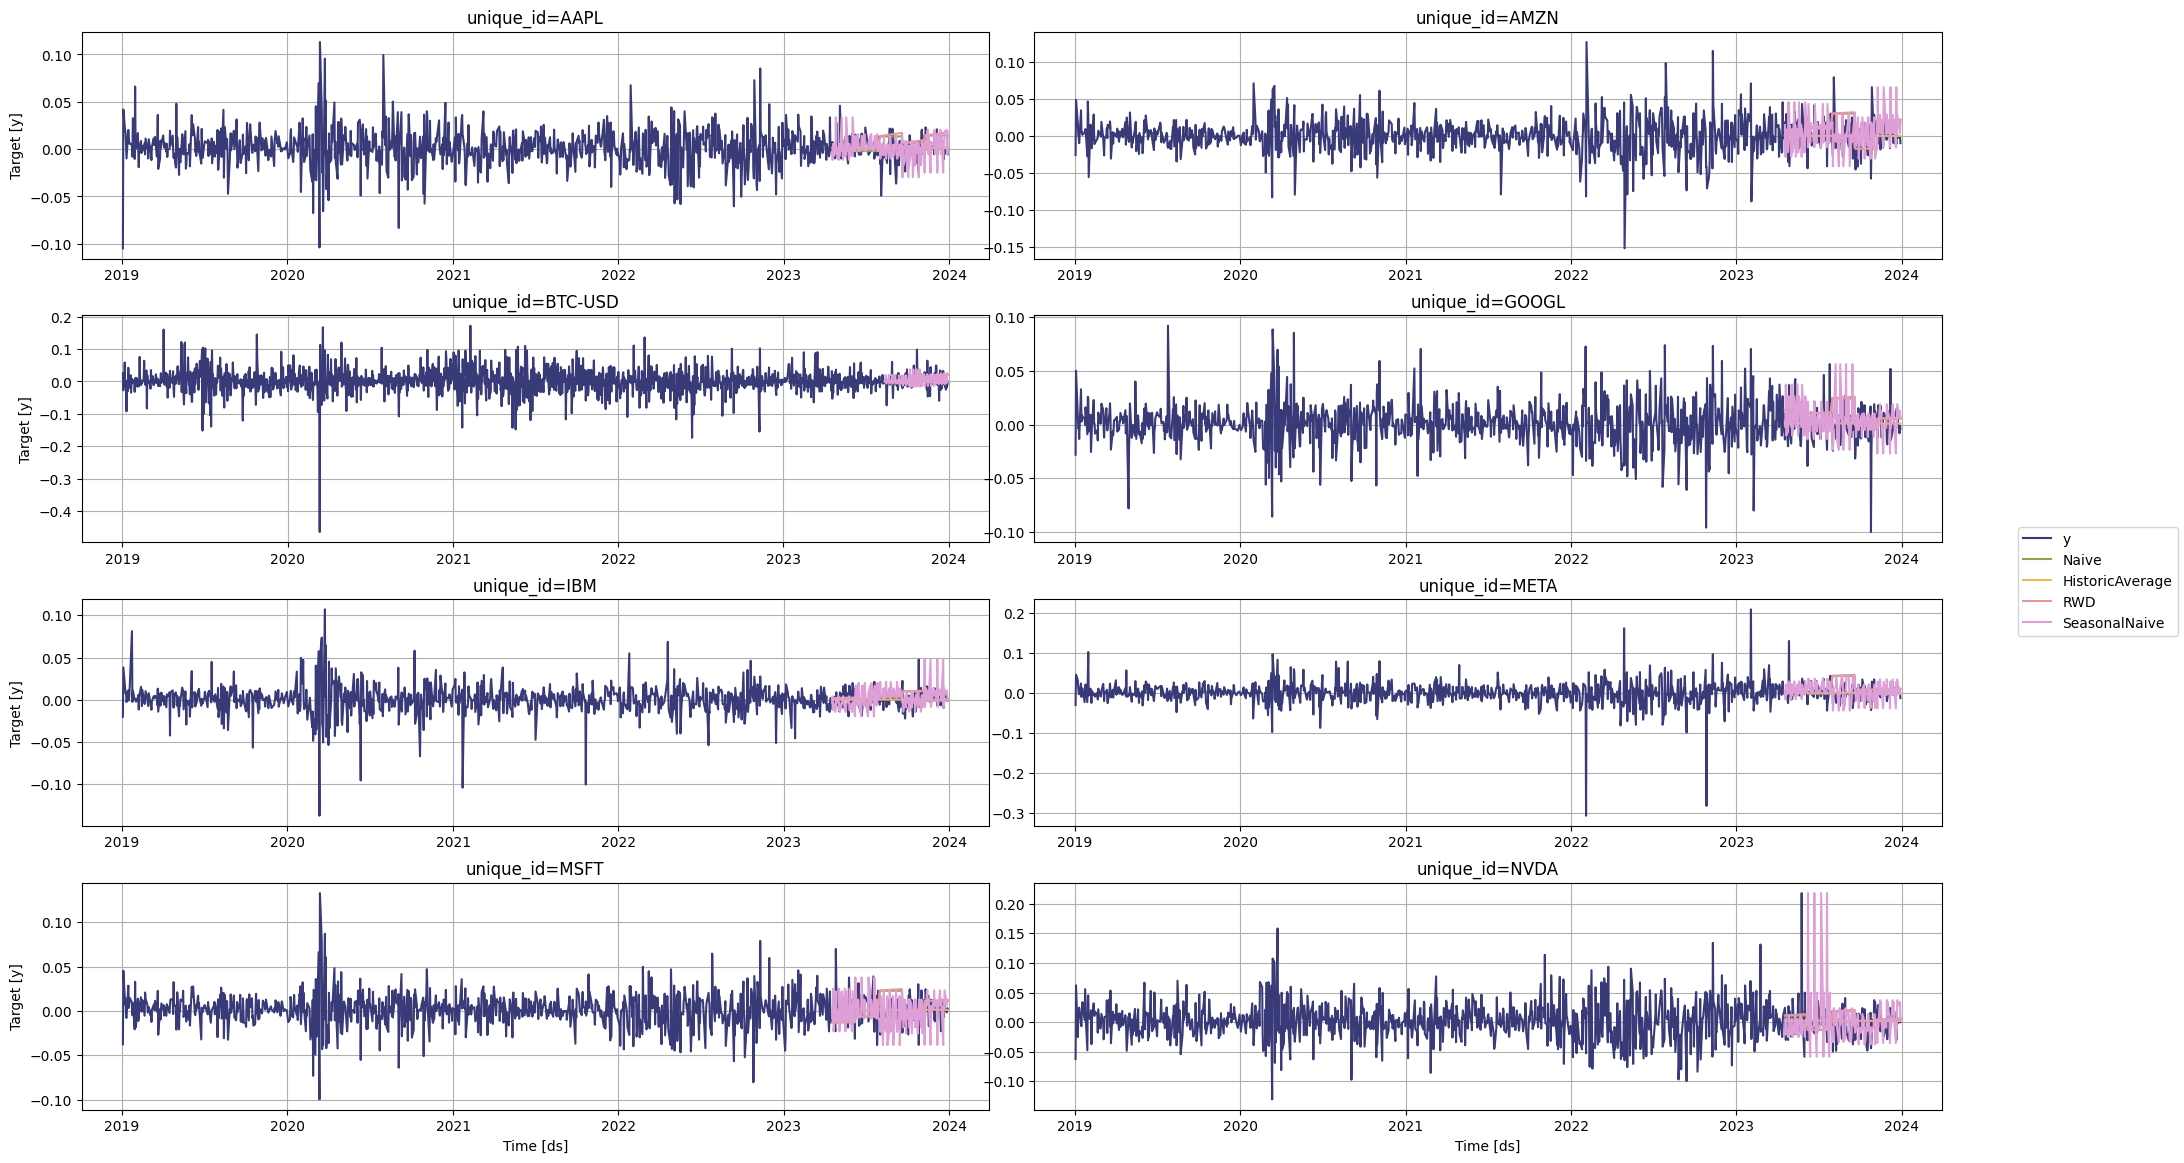

In [9]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))

In [10]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [11]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [12]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [13]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})


In [14]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-09 14:39:22,448 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 171f1d5949094bae0215ce09249b6ea8 initialized by task ('shuffle-transfer-171f1d5949094bae0215ce09249b6ea8', 1) executed on worker tcp://127.0.0.1:56231
2024-07-09 14:39:26,124 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 171f1d5949094bae0215ce09249b6ea8 deactivated due to stimulus 'task-finished-1720528766.120886'


,unique_id,cutoff,metric,Naive,HistoricAverage,RWD,SeasonalNaive
0,AAPL,2023-04-14,mse,0.000183,0.000159,0.000167,0.000393
1,AAPL,2023-04-14,mae,0.009476,0.008863,0.008839,0.01524
2,AAPL,2023-04-14,smape,164.058716,160.58963,171.559494,158.036682
3,AMZN,2023-06-06,mse,0.000404,0.000346,0.000412,0.000845
4,AMZN,2023-06-06,mae,0.015843,0.013726,0.015985,0.024829


In [15]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)


Naive  HistoricAverage         RWD  SeasonalNaive
cutoff     metric                                                        
2023-04-14 mae       0.016536         0.014812    0.016478       0.020489
           mse        0.00068         0.000635    0.000674       0.000947
           smape   153.613998       179.828156   152.40535     147.125977
2023-06-06 mae         0.0152         0.013398    0.015071       0.023841
           mse       0.000399         0.000315    0.000393        0.00168
           smape   155.085114       169.925461  156.707397     144.476547
2023-07-28 mae       0.027226         0.012005    0.028143       0.019374
           mse       0.001077         0.000282    0.001134       0.000661
           smape   157.567963       171.025238   158.41835     138.841278
2023-08-12 mae       0.012882         0.013092    0.012821       0.013905
           mse       0.000501         0.000507      0.0005       0.000449
           smape   177.086945       168.518524  183.120972     157.704697
2023-09-09 mae        0.01057         0.010506     0.01061       0.012932
           mse       0.000209         0.000202    0.000211       0.000288
           smape   184.174652       163.965759   178.40889     162.350983
2023-09-19 mae       0.016737         0.014777    0.016792       0.019863
           mse       0.000466         0.000402    0.000469       0.000625
           smape   148.332199       177.489014  150.255219     152.475998
2023-10-07 mae       0.014431         0.014406    0.014477       0.020215
           mse       0.000567         0.000562     0.00057       0.000948
           smape   183.094894       177.028854  187.626373     132.969666
2023-11-04 mae       0.017319         0.015914    0.017298       0.018279
           mse       0.000541         0.000516     0.00054       0.000484
           smape   136.226196       172.208817  136.580887     152.008469
2023-11-07 mae       0.012098         0.009411    0.012559         0.0176
           mse       0.000232         0.000147    0.000247       0.000535
           smape   133.509125       169.606552  134.386902     139.025803
2023-12-02 mae       0.024559         0.018031    0.024531       0.023599
           mse       0.000871         0.000555     0.00087       0.000768
           smape   134.840393       162.801361  134.835175     163.039001

In [16]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

<Axes: xlabel='error', ylabel='model'>

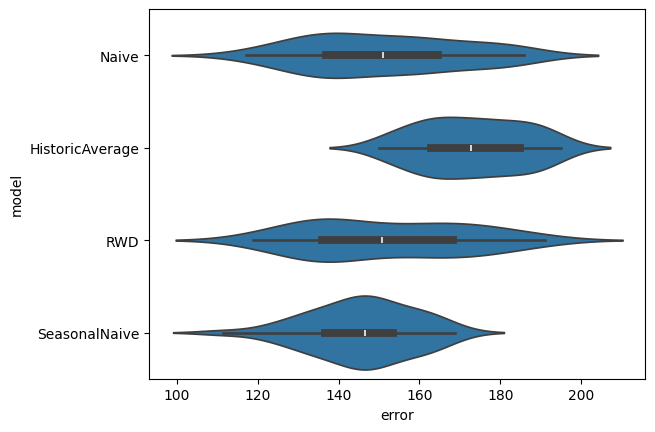

In [17]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

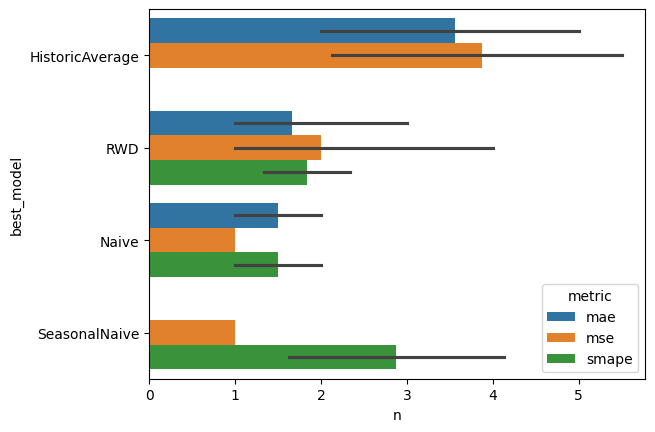

In [18]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')